# Angello Rodríguez Gutiérrez

# Prueba de evaluación 2

### Entornos de data science con Python

### Curso 2016/17.

## PARTE 1

En esta primera parte trabajaremos con APIs REST para buscar oportunidades de arbitraje con Bitcoin1. La idea es intentar buscar oportunidades en la que saliese rentable vender bitcoins en una moneda nacional (por ejemplo, en dólares), para después cambiar esa moneda fiat por otra (por ejemplo, Euros), y recomprar bitcoins. Por ejemplo, si tengo 1 BTC e instantáneamente (el que sea instantáneo es irreal, pero lo asumimos por simplicidad) que se vende por 1000 USD, y el tipo de cambio EUR/USD es 0.99, podría primero obtener los 1000 USD en una operación de venta, y con eso comprar 990 EUR. Si el precio de compra de 1 BTC es 980, podría adquirir el bitcoin original y aún me quedarían 10 EUR.

 1.- En una primera versión, haremos un script en Python que simplemente lea los precios en diferentes monedas fiat (tomar solamente tres, por ejemplo, USD, EUR y JPY) de 1 BTC (por ejemplo, en intervalos de 1 minuto o similar), que busque los tipos de intercambio entre algunas de las monedas en otro servicio REST2 y obtenga las oportunidades de compra/venta con arbitraje como la del ejemplo anterior. Nótese que los precios de compra y venta son en general diferentes.

In [5]:
#----------------------- At first we need to install these libraries from pip --------------------------

# pip install blockchain
# pip install fixerio

In [6]:
# coding: utf-8

from blockchain import exchangerates
from fixerio import Fixerio
import time

'''
INFO:
    ticker: Call the 'ticker' method and return 
            a dictionary of Currency objects.
    allowed_list: list of currencies that we will use.
    exchange_dict: the dictionary where we will put the data.

'''

ticker = exchangerates.get_ticker()
allowed_list = ["USD","JPY","EUR"]
exchange_dict = {
                    "USD": [],
                    "JPY": [],
                    "EUR": []    
                }
def reset_data_set():
    exchange_dict = {
                    "USD": [],
                    "JPY": [],
                    "EUR": []    
                }
    return exchange_dict

In [7]:
# ----------- function that returns a dcictionary with the currencies values -------------
'''
INFO:
    allowed_list: list of currencies that we will use.
    exchange_dict: the dictionary where we will put the data.

''' 
def get_exchange_rates(allowed_list,exchange_dict):
       
    for k in allowed_list:
        ticker_dict = {
                        "BUY" : '',
                        "SELL" : ''
                      }
        ticker_dict["BUY"] = ticker[k].buy
        ticker_dict["SELL"] = ticker[k].sell
        exchange_dict[k].append(ticker_dict)
        
    return exchange_dict


In [8]:
#------------------------ function to get data every N minutes --------------------------
'''
INFO:
    allowed_list: list of currencies that we will use.
    exchange_dict: the dictionary where we will put the data.
    
'''  
def exchange_process(allowed_list,exchange_dict):
    
    exchange_dict = get_exchange_rates(allowed_list,exchange_dict)
        
    return exchange_dict


In [9]:
#---------------------- function to get the current currencies -------------------------
'''
INFO:
    allowed_list: list of currencies that we will use

'''
def get_currency_values(allowed_list):
    
    currency_dict = {
                        "USD": '',
                        "JPY": '' 
                    }
    fxrio = Fixerio()
    fxrio = fxrio.latest()
    for k in allowed_list:
        if k !="EUR":
            currency_dict[k] = fxrio["rates"][k]
    return currency_dict


In [10]:
#-------------------------- function to see the oportunities ---------------------------
'''
INFO:
    allowed_list: list of currencies that we will use
    exchange_dict: the dictionary where we will put the data.
    duration: how much time the process will run
    hdf5: 0 to not use hdf5 and 1 to use it 
    return: a list with the best combinations to buy and sell when the script was running

IMPORTANT:
    THIS SCRIPT MAKES A REPORT EVERY 60 S 
'''

def get_oportunities(allowed_list,exchange_dict,duration,hdf5):
    
    list_best_combinations = []
    
    while duration != 0:
        
        exchange_dict_to_cast = exchange_process(allowed_list,exchange_dict)
        currency_cast_dict = get_currency_values(allowed_list)
        exchange_cast_dict = {
                        "USD": [],
                        "JPY": [],
                        "EUR": []    
                    }
        for k,v in exchange_dict_to_cast.iteritems():
            ticker_cast_dict = {
                            "BUY" : '',
                            "SELL" : ''
                          }
            if k != "EUR":
                for currency_values in v:
                    ticker_cast_dict["BUY"] = cast_function(k,currency_values["BUY"],currency_cast_dict)
                    ticker_cast_dict["SELL"] = cast_function(k,currency_values["SELL"],currency_cast_dict)
                    exchange_cast_dict[k].append(ticker_cast_dict)
            else:
                for currency_values in v:
                    exchange_cast_dict[k].append(currency_values)

        formated_data = data_formater(exchange_cast_dict)
        data = cast_to_data_frame(formated_data)
        if hdf5 != 0:
            data.to_csv("data.csv",sep=";")
            get_data_from_hdf5()
        prueba = get_best_combination(data)
        list_best_combinations.append(prueba)
        
        duration -= 1
        time.sleep(60)
    
    return list_best_combinations
                
                

In [11]:
#------------------------ Function to cast to euros -----------------------------------

def cast_function(currency_key,currency_value,currency_dict):
    
    cast_value = currency_value/currency_dict[currency_key]
    
    return cast_value 

In [12]:
#---------------------- Data Frame format function ------------------

def data_formater(dict_final):
    formated_data = []
    for k,v in dict_final.iteritems():
        count = 0
        for iteration in v:

            count += 1
            dict_to_frame = {
                            "ID_ITERATION" : (str(count)+k).encode("utf-8"),
                            "COUNTRY" : k.encode("utf-8"),
                            "SELL" : str(iteration["SELL"]).encode("utf-8"),
                            "BUY" : str(iteration["BUY"]).encode("utf-8")
                        }
            formated_data.append(dict_to_frame)
    return formated_data
    


In [13]:
#---------- Function to cast the data structure to Data Frame ----------

import pandas as pd

def cast_to_data_frame(formated_data):
    data = pd.DataFrame(formated_data)
    return data

In [14]:
#-------- Function to get the best combination to buy and sell ---------

def get_best_combination(data):
    dict_best_combination = {
                                "COUNTRY_TO_BUY" : data[["BUY","COUNTRY"]].min()[1],
                                "AMOUNT_TO_BUY" : data[["BUY","COUNTRY"]].min()[0],
                                "COUNTRY_TO_SELL" : data[["SELL","COUNTRY"]].max()[1],
                                "AMOUNT_TO_SELL" : data[["SELL","COUNTRY"]].max()[0]
                            }
    return dict_best_combination



In [15]:
#------- Example to run the script and see the information -------------

'''
INFO:
    allowed_list: list of currencies that we will use
    exchange_dict: the dictionary where we will put the data.
    duration: how much time the process will run
    hdf5: 0 to not use hdf5 and 1 to use it 
    return: a list with the best combinations to buy and sell when the script was running

IMPORTANT:
    THIS SCRIPT MAKES A REPORT EVERY 60 S 
'''

lista_final_comb = get_oportunities(allowed_list,exchange_dict,1,0)

print lista_final_comb

[{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': '1107.82711694', 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': '1114.63'}]


##### 2.- Basándonos en las ideas de esa primera versión, modificar el script para que grabe en disco en un fichero HDF5 las series temporales de diferencias entre pares de monedas como la descrita en el ejemplo anterior (todas, positivas o negativas). Después, en un Notebook se leerán las series del fichero, obteniendo los máximos y mínimos y dibujando las series para intentar comparar los diferentes pares de monedas. El tiempo será el de la ejecución de cada iteración del script.

In [175]:
import os
import tables as tb
import numpy as np
import gc
from tables import ClosedFileError
import plotly.plotly as py
import matplotlib.pyplot as plt

#----------- Function to save data into HDF5 file ---------------
def cast_to_hdf5():
    try:
        os.remove("c_data.h5")
    except OSError:
        pass
    f = tb.open_file("c_data.h5", "w", title="currency data")
    f.create_group("/", "currency_data", "Currency Data")
    f.close()
    store = pd.HDFStore('c_data.h5',mode='w')
    lines = 100
    for chunk in pd.read_csv('data.csv',sep=";",header=0,chunksize=lines): 
        store.append('currency_data',chunk)
    data_from_hdf5 = store.select("currency_data")
    f.close()
    store.close()
    
    return data_from_hdf5

#-----------Function to get the best combination from HDF5 file and some plots -----------
def get_data_from_hdf5():
    data_from_hdf5 = cast_to_hdf5()
    dict_best_combination = {
                                "COUNTRY_TO_BUY" : data_from_hdf5[["BUY","COUNTRY"]].min()[1],
                                "AMOUNT_TO_BUY" : data_from_hdf5[["BUY","COUNTRY"]].min()[0],
                                "COUNTRY_TO_SELL" : data_from_hdf5[["SELL","COUNTRY"]].max()[1],
                                "AMOUNT_TO_SELL" : data_from_hdf5[["SELL","COUNTRY"]].max()[0]
                            }
    print dict_best_combination
    %matplotlib inline
    plt.figure();
    data_from_hdf5[["BUY","COUNTRY"]].plot(kind='line'); plt.axhline(0, color='k')
    
    plt.figure();
    data_from_hdf5[["SELL","COUNTRY"]].plot(kind='line'); plt.axhline(0, color='k')
    
    plt.figure();
    data_from_hdf5[["SELL","BUY"]].plot.box()

{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_TO_BUY': 'EUR', 'AMOUNT_TO_BUY': 1099.6499496, 'COUNTRY_TO_SELL': 'USD', 'AMOUNT_TO_SELL': 1106.08}
{'COUNTRY_

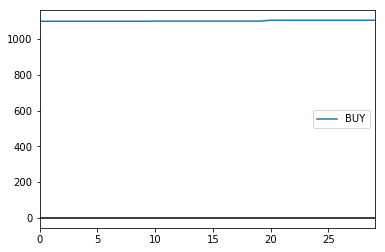

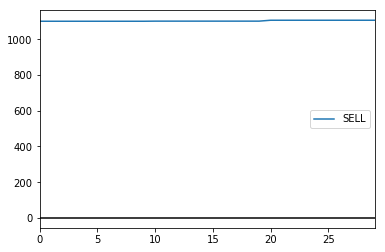

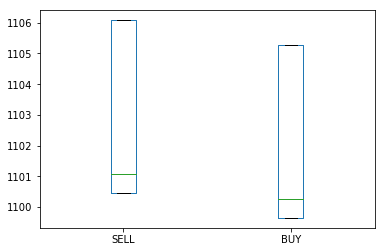

In [176]:
#------- Example to run the script and see the information from HDF5-------------

'''
INFO:
    allowed_list: list of currencies that we will use
    exchange_dict: the dictionary where we will put the data.
    duration: how much time the process will run
    hdf5: 0 to not use hdf5 and 1 to use it 
    return: a list with the best combinations to buy and sell when the script was running

IMPORTANT:
    THIS SCRIPT MAKES A REPORT EVERY 60 S 
'''

exchange_dict = reset_data_set()
lista_final_comb = get_oportunities(allowed_list,exchange_dict,10,1)

Observamos que es posible obtener beneficios si compramos bitcoins en ciertos países y los vendemos en otros, el resultado obtenido en este estudio nos dice que por lo general la combinación más beneficiosa es  comprarlos en euros y venderlos en dolares obteniendo un beneficio de  ~= 6,40 €. Este beneficio incremente en gran cantidad si invertimos un monto considerable. Sin embargo la complejidad estaría en la automatización del proceso de compra y venta en tiempo real ya que al tratarse de algo tan volatil como es la devaluación de moneda tienen que ser operaciones cuyas transacciones tienen que realizarse de manera muy rápida, esto quiza pueda solucionarse utilizando ciertas herramientas apropiadas a un sistema de baja latencia como sería este. Otro factor a tener en cuenta sería el tiempo que tardan los servicios de compra y venta de bitcoins así como de cambio de moneda ya que al ser externos dependeremos de sus tiempos. 

## PARTE 2

En esta segunda parte continuaremos con uno de los ejercicios de la PEC1. Concretamente, intentaremos completar el dataset de los accidentes de aviones con datos que se pueden encontrar en Internet. La idea es ampliar el dataset con nuevas columnas, tomando información mediante scraping de páginas Web u otros métodos de adquisición si se encuentran. Una fuente posible es Wikipedia: https://en.wikipedia.org/wiki/Breguet_14 
Particularmente, en el cuadro que aparece a la derecha parece haber información semiestructurada. No obstante, las URL no siguen un esquema de nombrado uniforme en todos los casos.

Se pide:
- Estudiar el problema de adquisición.
- Enviar el código utilizado para obtener los datos adicionales, de acuerdo a lo estudiado.
- Enviar un fichero de texto RESUMEN.TXT donde se resuman cuantitativamente los datos que se han conseguido obtener, qué atributos o variables se han extraído, qué número de filas de cada atributo.

In [216]:
import pandas as pd

airplanes_set = pd.read_csv('airplanes_set.csv')

def clean_data_airplanes(airplane):
    clean_str = ""
    airplane_split = str(airplane).split()
    for item in airplane_split:
        if "(" not in item and "/" not in item:
            clean_str += item + " "
    clean_str = clean_str.replace("-"," ")
    clean_str = clean_str.replace("."," ")
    clean_str = clean_str.replace(","," ")
    clean_str = clean_str.replace(";"," ")
    return clean_str


list_airplanes = airplanes_set["Type"].unique()
clean_list =[]

for plane in list_airplanes:
    clean_list.append(clean_data_airplanes(plane))

Lo primero que vemos es que tenemos que limpiar los datos para que wikipedia reconozca más fácilmente el contenido, limpiando el contenido entre paréntesis o barras

In [229]:
from bs4 import BeautifulSoup
import cookielib, urllib2
import json
import csv

#---------------------- Variables to send a request and the main url ---------------------

cj = cookielib.CookieJar()
opener = urllib2.build_opener(urllib2.HTTPCookieProcessor(cj))
ROOT = "https://en.wikipedia.org/wiki/"

#------------------ Function to clean white spaces, tabs and new lines --------------  

def clean_data(data):
    
    data = data.strip()
    data = data.replace("\n","")
    data = data.replace("\t","")
    return data

#--------------- Function to extract data from wikipedia from an url given ----------

def get_data_from_wiki(url):
    
    try:
        lurl = opener.open(url)
        parse = BeautifulSoup(lurl.read(),'html')
        rows = parse.find(class_='infobox').find_all('tr')
        plane_dict = {}
        for row in rows:

            # Condition to see how many cells we find, and just take data when we got 2 

            if row.find('td')!=None  and  row.find('th')!=None:
                key = clean_data(row.find('th').get_text().encode('utf-8'))
                value = clean_data(row.find('td').get_text().encode('utf-8'))
                plane_dict[key] = value
        return plane_dict
    except:
        pass
   

In [12]:
#--------------------------------- MORE SCRAPER, TAKE CARE :,) ------------------------------------

from bs4 import BeautifulSoup
import cookielib, urllib2
import json
import csv

#---------------------- Variables to send a request and the main url ---------------------

cj = cookielib.CookieJar()
opener = urllib2.build_opener(urllib2.HTTPCookieProcessor(cj))
main_page = "https://en.wikipedia.org/wiki/"

#--------------- Extramos el contenido de la url y nos devuelve un diccionario ----------

def extract_data(url):
    
    try:
        req = opener.open(url)
        parse = BeautifulSoup(req.read(),'html')
        rows = parse.find(class_='infobox').find_all('tr')
        data_dict = {}
        
        for row in rows:
            # Condition to see how many cells we find, and just take data when we got 2 
            if row.find('td')!=None  and  row.find('th')!=None:
                clave = row.find('th').get_text()
                
                valor = row.find('td').get_text()
                
                data_dict[clave] = valor
        return data_dict
    
    except:
        pass
   
#Seria ya como te hayas montado el frame del ejercicio 1 pero te dejo funciones de tratamiento y conexión con la lista de urls
#Te dejo como sería la extraccion de aviones del frame

# list_airplanes = airplanes_set["Type"].unique() ----> te da una lista de strings que es lo que metes en la funcion de abajo
# que sirve para montar la url
def extract_data_from_list(url_list):
    
    clean_url_list =[]
    for item in url_list:
        clean_value = ""
        value_split = str(item).split()
        for splited_item in value_split:
            if "(" not in splited_item and "/" not in splited_item:
                clean_value += splited_item + " "
        #abajo se monta la url a buscar       
        url_to_extract = main_page + clean_value
        dict_extracted = extract_data(url_to_extract)
        # Te recomendaria meter los dics en un fichero porque tarda la vida en cargar y si actualizas se va y de fichero 
        # es un load solo en mi codigo sale como meterlo a fichero, de momento de lo dejo sin guardar porque dependo de 
        # como tengas tu frame para la integracion. tienes que hacer un: fichero.write(json.dumps(dict_extracted)) y se 
        # guarda como dic en el fichero, para sacarlo cuando recorras el fichero con un: for item in lista_dics:
        # para que ese item se reconozca como un diccionario para meterlo en un frame o algo tiene que hacer 
        # dict = json.loads(item)
        
        print dict_extracted 

lista_prueba_more_mira_que_scraper_puta_madre_XD = ["Wright Flyer III","Armstrong Whitworth F K 8"]
        
extract_data_from_list(lista_prueba_more_mira_que_scraper_puta_madre_XD)
    


{u'Designer': u'Orville and Wilbur Wright', u'First flight': u'June 23, 1905', u'Developed from': u'Wright Flyer II', u'Preserved at': u'Dayton Aviation Heritage National Historical Park', u'National origin': u'United States', u'Role': u'Experimental airplane', u'Number built': u'1'}
{u'Designer': u'Frederick Koolhoven', u'First flight': u'May 1916', u'Developed from': u'Armstrong Whitworth F.K.7', u'Primary\xa0users': u'Royal Flying Corps\nQantas', u'Role': u'Bomber/Reconnaissance aircraft', u'Manufacturer': u'Armstrong Whitworth', u'Number built': u'1,650'}


In [230]:
PATH_TO_SEND_DATA = "new_airplane_data.txt"

def load_airplane_data(url_list):
    
    file_to_send_data = open(PATH_TO_SEND_DATA,"a")
    for url in url_list:
        url_joined = ""
        url_joined = ROOT + url 
        print url_joined
        plane_dict = get_data_from_wiki(url_joined)
        if plane_dict!= {}:
            print plane_dict
            file_to_send_data.write(json.dumps(plane_dict))
            file_to_send_data.write("\n")

    file_to_send_data.close()
    
load_airplane_data(clean_list)



https://en.wikipedia.org/wiki/Wright Flyer III 
{'Designer': 'Orville and Wilbur Wright', 'First flight': 'June 23, 1905', 'Developed from': 'Wright Flyer II', 'Preserved at': 'Dayton Aviation Heritage National Historical Park', 'National origin': 'United States', 'Role': 'Experimental airplane', 'Number built': '1'}
https://en.wikipedia.org/wiki/Dirigible 
None
https://en.wikipedia.org/wiki/Curtiss seaplane 
None
https://en.wikipedia.org/wiki/Zeppelin L 1 
None
https://en.wikipedia.org/wiki/Zeppelin L 2 
None
https://en.wikipedia.org/wiki/Zeppelin L 8 
None
https://en.wikipedia.org/wiki/Zeppelin L 10 
None
https://en.wikipedia.org/wiki/Schutte Lanz S L 10 
None
https://en.wikipedia.org/wiki/Zeppelin L 32 
None
https://en.wikipedia.org/wiki/Zeppelin L 31 
None
https://en.wikipedia.org/wiki/Super Zeppelin 
None
https://en.wikipedia.org/wiki/Zeppelin L 34 
None
https://en.wikipedia.org/wiki/Airship 
None
https://en.wikipedia.org/wiki/Schutte Lanz S L 9 
None
https://en.wikipedia.org/wiki

Como podemos observar no todos los aviones nos han devuelto datos al tratar de extraer sus datos de Wikipedia. Como resultado del proceso de extracción hemos obtenido un fichero de texto con el "raw data" de los nuevos datos extraidos.

In [335]:
#------------------------- Constants -----------------------------

PATH_RAW_DATA = "new_airplane_data.txt"
PATH_USEFUL_DATA = "useful_data.txt"
PATH_RESUMEN = "RESUMEN.txt"

#------------- Function to get the useful data (not NULLS) -----------

def get_useful_data(raw_data_path,useful_path):
    raw_data_file = open(raw_data_path,'r')
    useful_file = open(useful_path,'w')
    
    list_data = []
    total_data = 0
    list_raw_data = []
    
    for line in raw_data_file:
        total_data += 1
        if line!= "null\n":
            list_raw_data.append(line)
            useful_file.write(json.dumps(json.loads(line)))
            useful_file.write("\n")
    
    useful_file.close()
    raw_data_file.close()
    print len(list_raw_data)
    return list_raw_data,total_data


In [336]:
#---------------- Function to get the diferent keys from file ----------

def get_diferent_keys(useful_path):
    
    diferent_keys = []
    useful_file = open(useful_path,'r')
    for line in useful_file:
        dict_from_file = json.loads(line)
        for k,v in dict_from_file.iteritems():
            if k not in diferent_keys:
                key = k.split()
                key_str = "_".join(key)
                diferent_keys.append(key_str)
    useful_file.close()        
        
    return diferent_keys

#-------------- Function to count how many rows use these keys -----------

def count_diferent_keys(useful_path):
    
    useful_file = open(useful_path,'r')
    dictionary_to_count = {}
    
    dife = get_diferent_keys(PATH_USEFUL_DATA)
    for i in dife:
        dictionary_to_count[str(i)] = 0
    for key_dict in useful_file:
        useful_dict = json.loads(key_dict)
        for k,v in useful_dict.iteritems():
            k_formated = "_".join(k.split())
            dictionary_to_count[k_formated] += 1
    useful_file.close()
    
    return dictionary_to_count


In [340]:
#----------------- Function to write all the information in a log -------------------

def log_resumen(log_path,data_path,useful_path):
    
    dict_to_count = count_diferent_keys(useful_path)
    useful_data,total_data = get_useful_data(data_path,useful_path)
    useful_rows = len(useful_data)
    useless_data = total_data - useful_rows

    log_file = open(log_path,"w")
    log_file.write("################################################################\n") 
    log_file.write("####              NEW AIRPLANE DATA SET STATISTICS          ####\n") 
    log_file.write("################################################################\n") 
    useful_kpi = "#  USEFUL DATA : " + str(useful_rows) + "\n"
    useless_kpi = "#  USELESS DATA : " + str(useless_data) + "\n"
    log_file.write(useful_kpi) 
    log_file.write(useless_kpi) 
    log_file.write("################################################################\n") 
    log_file.write("####                      FOUND COLUMNS                     ####\n") 
    log_file.write("####   COLUMN     |     REPETITIONS                         ####\n") 
    log_file.write("################################################################\n") 
                   
    for k,v in dict_to_count.iteritems():
        formated_data = " - " + k + " : " + str(v) + "\n"
        log_file.write(formated_data) 
    log_file.close()
    


In [ ]:
#------- Example to run the script and see the information ------------

log_resumen(PATH_RESUMEN,PATH_RAW_DATA,PATH_USEFUL_DATA)

De esta manera obtenemos un informe con la siguiente forma:

################################################################
####              NEW AIRPLANE DATA SET STATISTICS          ####
################################################################
#  USEFUL DATA : 4743
#  USELESS DATA : -2295
################################################################
####                      FOUND COLUMNS                     ####
####   COLUMN     |     REPETITIONS                         ####
################################################################
 - Former_type : 8
 - Introduction : 197
 - Media : 1
 - Release_date : 1
 - Key_people : 11
 - Destinations : 2
 - Primary_users : 141
 - Ceased_operations : 2
 - Role : 265
 - Built_by : 6
 - Unit_cost : 67
 - Controller_input : 1
 - Fleet_size : 2
 - Subsidiaries : 2
 - Type : 1
 - CPU : 1
 - Product_family : 1
 - Status : 144
 - Produced : 187
 - Designer : 53
 - Fate : 11
 - Developed_into : 53
 - Units_sold : 1
 - Discontinued : 1
 - Connectivity : 1
 - Developed_from : 106
 - Parent_company : 1
 - Best-selling_game : 1
 - Number_built : 245
 - Number_of_employees : 7
 - Successor : 11
 - Sound : 1
 - Website : 8
 - Defunct : 10
 - Operating_bases : 1
 - Storage : 1
 - Industry : 3
 - IATA : 2
 - Headquarters : 13
 - National_origin : 126
 - Developer : 1
 - Products : 1
 - Predecessor : 1
 - Hubs : 1
 - Primary_user : 52
 - Variants : 93
 - Retired : 56
 - Parent : 1
 - Generation : 1
 - Retail_availability : 1
 - Founded : 13
 - Memory : 1
 - Preserved_at : 2
 - Design_group : 4
 - Manufacturer : 259
 - First_flight : 250


## PARTE 3

El sitio Web NOOA del gobierno de EEUU proporciona datasets de datos climáticos a través de esta página Web: http://www.ncdc.noaa.gov/cdo-web/datasets
Entre ellos tenemos los datasets “Quality Controlled Local Climatological Data (QCLCD)” que se describen aquí: http://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/quality-controlled-local-climatological-data-qclcd

Entre los datos que se encuentran en los datasets QCLCD están las precipitaciones por años y estaciones. Por ejemplo, podemos descargar los datasets de aquí: http://www.ncdc.noaa.gov/orders/qclcd/

Y encontraremos ficheros con datos de precipitaciones como este:

 Wban Number, YearMonthDay, Time, Hourly Precip
 03013,19960701,0053,0
 03013,19960701,0153,0
 03013,19960701,0253,0
 03013,19960701,0353,0
 03013,19960701,0453,0

Se pide tomar datos de varios años (queda a la elección del estudiante) de este conjunto de datasets para las precipitaciones y obtener los siguientes resúmenes:
 - Día en que ha habido más precipitaciones.
 - Año en que ha habido más precipitaciones (obteniendo la media de cada año)
Se pide realizar el análisis en dos versiones:
 - Una utilizando DataFrames y los ficheros de texto que se decargan directamente.
 - Una segunda con un paso previo en el que se guardan los datos en un fichero HDF5 (que debe contener los metadatos descriptivos necesarios). Queda a la decisión del estudiante cómo organizar los datos en el fichero.
 Y se pide comparar:
 - El tamaño en disco que ocupan los datos en cada una de las versiones.
 - El tiempo comparado de ejecución de los resúmenes anteriores.

Opcional: finalmente, se platea el almacenar en el fichero HDF5 los resúmenes mismos obtenidos y comparar el tiempo de recuperación de esos datos del fichero con el tiempo tardado en calcularlo.